# **Import needed libraries**

In [13]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# **Loading the dataset**

> Read the training dataset into the dataframe

In [14]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}


    df[column_name] = df[column_name].replace(index)

In [15]:
# loading the data
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths               labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
...                                                  ...                  ...
14995  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14996  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14997  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14998  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14999  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue

[15000 rows x 2 columns]

# **Data preprocessing**

first we will check if the training data is balanced or not

In [16]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

It is balanced, now we will split our data to train, val and test set

In [17]:
# data --> 80% train data && 20% (test, val)
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

**Create image data generator**

in this step we will convert the whoole data to numpy arrays

In [18]:
# crobed image size
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


**Display sample from train data**

In [19]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(6, 6, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

# **Create needed functions**

In [20]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred


# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()
    
    
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block


# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

# **Model Structure**

# **CNN model**

# **EfficientNetB3**

In [21]:
# get the pre-trained model (EfficientNetB3)
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

# fine-tune EfficientNetB3 (Adding some custom layers on top)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = dense_block(128, 0.5)(x)
x = dense_block(32, 0.2)(x)
predictions = Dense(class_counts, activation = "softmax")(x)    # output layer with softmax activation

# the model
EfficientNetB3_model = Model(inputs = base_model.input, outputs = predictions)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
EfficientNetB3_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,991,282 (41.93 MB)

 Trainable params: 10,900,587 (41.58 MB)

 Non-trainable params: 90,695 (354.28 KB)

In [23]:
# train the model
epochs = 20   # number of all epochs in training

EfficientNetB3_history = EfficientNetB3_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20


W0000 00:00:1727803459.246932     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6234 - loss: 0.9626

W0000 00:00:1727803562.108656     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 292s 346ms/step - accuracy: 0.6237 - loss: 0.9618 - val_accuracy: 0.3247 - val_loss: 1.2769
Epoch 2/20


W0000 00:00:1727803588.866962     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 270ms/step - accuracy: 0.8871 - loss: 0.3226 - val_accuracy: 0.6453 - val_loss: 1.2947
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 270ms/step - accuracy: 0.9347 - loss: 0.1916 - val_accuracy: 0.9867 - val_loss: 0.0570
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.9619 - loss: 0.1295 - val_accuracy: 0.9927 - val_loss: 0.0347
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9748 - loss: 0.0925 - val_accuracy: 0.9953 - val_loss: 0.0224
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 270ms/step - accuracy: 0.9751 - loss: 0.0849 - val_accuracy: 0.9987 - val_loss: 0.0148
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9869 - loss: 0.0536 - val_accuracy: 0.9980 - val_loss: 0.0118
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 270ms/step - accuracy: 0.9884 - loss: 0.0450 - val_accuracy: 0.9993 - val_loss: 0.0084
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 101s 269ms/step - accuracy: 0.9909 - loss: 0.04

**Display model performance**

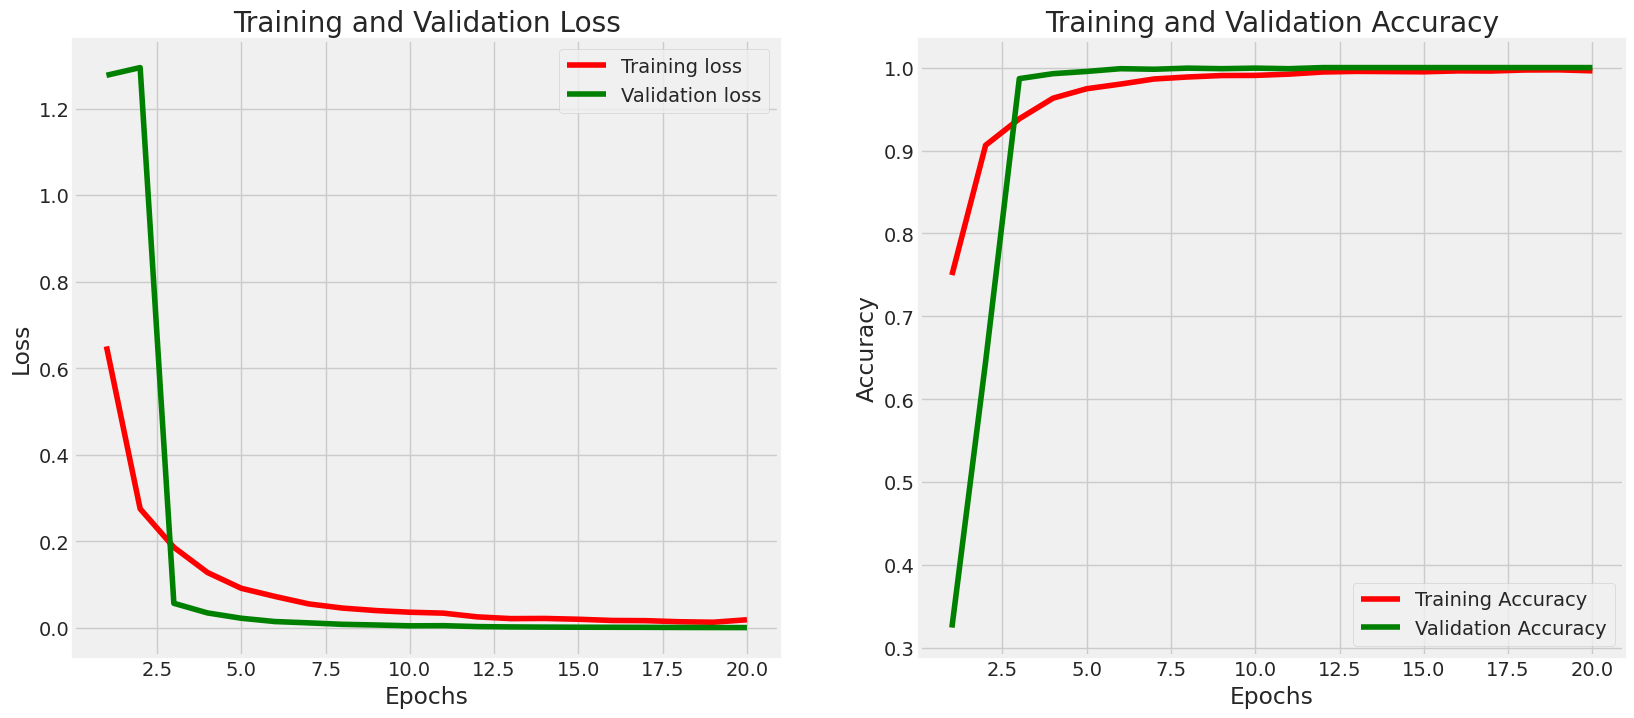

In [24]:
# Display model performance
model_performance(EfficientNetB3_history, epochs)

**Evaluate the model**

In [25]:
# Model evaluation
model_evaluation(EfficientNetB3_model)

375/375 ━━━━━━━━━━━━━━━━━━━━ 50s 134ms/step - accuracy: 1.0000 - loss: 5.6858e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 8.9951e-04
47/47 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 1.0000 - loss: 0.0014
Train Loss:  0.0005673323757946491
Train Accuracy:  1.0
--------------------
Validation Loss:  0.0008799320203252137
Validation Accuracy:  1.0
--------------------
Test Loss:  0.0014200045261532068
Test Accuracy:  1.0


**Get predictions and display the confusion matrix**

 3/47 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step

W0000 00:00:1727805627.579942     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 313ms/step


W0000 00:00:1727805641.957510     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


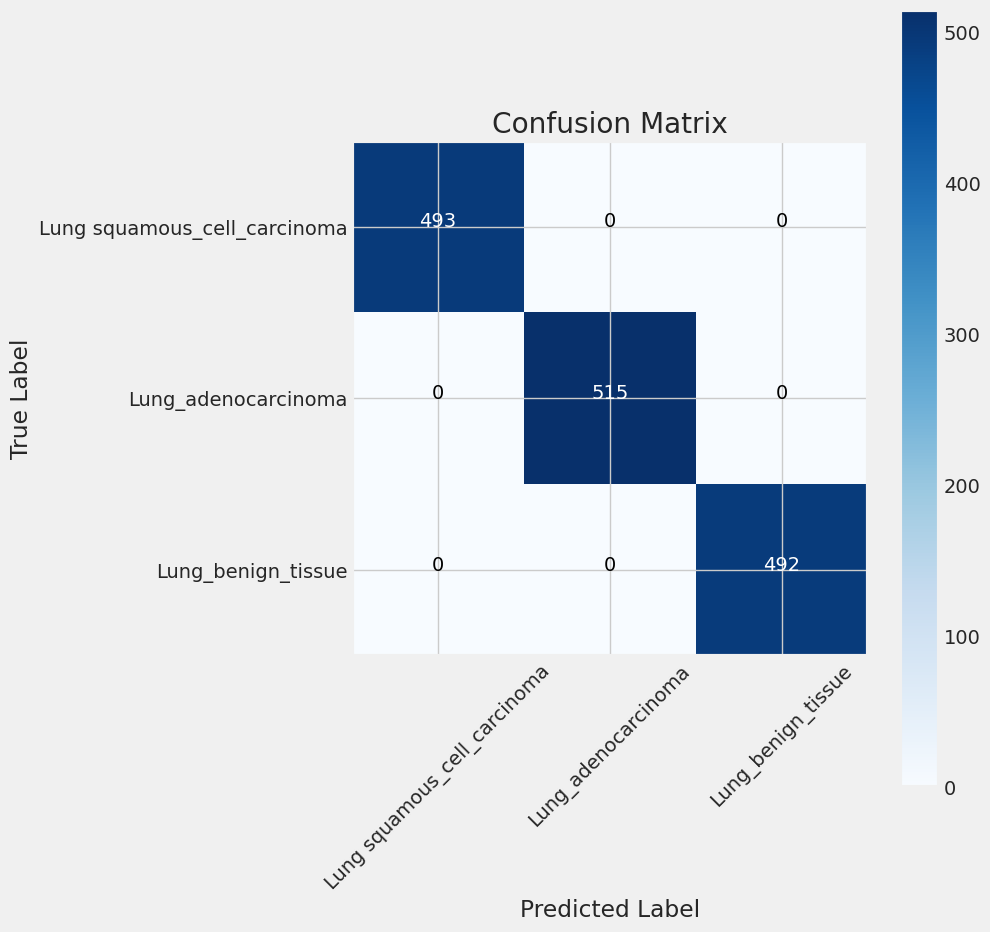

In [26]:
# get predictions
y_pred = get_pred(EfficientNetB3_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred)

In [28]:
# Save model in H5 format
EfficientNetB3_model.save('efficientnetb3_model.h5')
print("Model saved as efficientnetb3_model.h5")

Model saved as efficientnetb3_model.h5
